In [1]:
using Plots
import Plots: px
theme(:default)
ENV["LINES"] = 20

20

In [2]:
include("parser.jl")
include("models.jl")
gpu()
download(SIGDataSet)

true

In [3]:
data  = map(parseDataLine, eachline("./data/Sigmorphon/task1/all/spanish-train-high"));
vocab = Vocabulary(data)
edata = encode(data,vocab);
test  = map(parseDataLine, eachline("./data/Sigmorphon/task1/all/spanish-test"));
tdata = encode(test,vocab);
dictionary = [parseDataLine(line) for line in  eachline("./data/unimorph/spa/spa") if line != ""];

In [4]:
vocab.chars.toElement;

In [5]:
vocab.specialIndices

(unk = 1, mask = 2, eow = 3, bow = 4)

In [6]:
trainsfs = unique(map(x->join(x.surface),data));
testsfs  =  unique(map(x->join(x.surface),test)); 
dictsfs  = unique([map(x->join(x.surface),dictionary); trainsfs; testsfs]);

In [9]:
morph = EncAttentiveVAE(length(vocab.chars); H=512, E=16, Z=16)
train_ae!(morph, data, vocab; optim=Adam(), epoch=50)

(loss = 27.142887371826173,)
(loss = 21.925279620361326,)


InterruptException: InterruptException:

In [8]:
morphv =  EncAttentiveVAE(length(vocab.chars); H=512, E=16, Z=16)
copytoparams(morphv.encoder, morph.encoder)
copytoparams(morphv.Wμ, morph.Wμ)
copytoparams(morphv.Wσa, morph.Wσa)
copytoparams(morphv.Wμa, morph.Wμa)
copytoparams(morphv.Wσ, morph.Wσ)
copytoparams(morphv.Weaμ, morph.Weaμ)
copytoparams(morphv.Weaσ, morph.Weaσ)
morphv.decoder.embedding = morphv.encoder.embedding
train_vae!(morphv, data, vocab; optim=Adam(), epoch=45, kl_weight=0.0f0, kl_rate = 0.1f0, fb_rate=3)

(kl_weight = 0.1f0, fbr = 3, loss = 24.400968673706053)
(kl_weight = 0.2f0, fbr = 3, loss = 20.668558029174804)


InterruptException: InterruptException:

In [21]:
samples = sample(morphv, vocab, edata; N=10000);

In [22]:
unique(samples[findall([s ∈ trainsfs for s in samples])])

3657-element Array{String,1}:
 "espolvorease" 
 "reteñiríais"  
 "reflexionáis" 
 "aruñabais"    
 "amarillecía"  
 "empodrecéis"  
 "empollaran"   
 "te arrodilles"
 ⋮              
 "likeare"      
 "aguijonee"    
 "robusteciera" 
 "opositaba"    
 "acaparad"     
 "vengarán"     
 "no infundas"  

In [23]:
length(samples[findall([s ∈ trainsfs for s in samples])])

5608

In [24]:
unique(samples[findall([s ∈ testsfs for s in samples])])

9-element Array{String,1}:
 "sistematizaba"
 "decore"       
 "puntaren"     
 "taconearíamos"
 "no laven"     
 "enrole"       
 "loqueare"     
 "desobstruimos"
 "doblegare"    

In [25]:
length(samples[findall([s ∈ testsfs for s in samples])])

10

In [26]:
unique(length(samples[findall([s ∈ dictsfs for s in samples])]))

1-element Array{Int64,1}:
 6804

In [27]:
sampleinter(morphv, vocab, data; N=10)

12-element Array{String,1}:
 "encastillad"  
 "encastillad"  
 "encastillad"  
 "encastillad"  
 "encastillados"
 "acompañaran"  
 "acompañaran"  
 "acompañaran"  
 "acompañaran"  
 "acompañaran"  
 "acompañaran"  
 "acompañaran"  

In [28]:
au, sigma, mu = calc_au(morphv,tdata; delta=0.01)

(16, Float32[0.04300758; 0.04325096; … ; 0.045190305; 0.044187315], K32(16,1)[0.25393218⋯])

In [19]:
mi = calc_mi(morphv,tdata)

0.01842317199707111

In [20]:
calc_ppl(morphv,tdata)

6.255561420142625

In [29]:
atts = attentions(morph,edata, vocab);

In [30]:
function getsingle(sfs,exs,perms, αs,i) 
    join(vocab.chars[sfs[i]]), map(e->join(vocab.chars[e]),exs[i][perms[i]]), map(x->x[:,perms[i],i],αs)
end

getsingle (generic function with 1 method)

In [31]:
i = rand(1:length(atts))
s1,e1,α1 =  getsingle(atts[i]...,rand(1:16))
ys = 1:512
h1 = heatmap(e1, ys, α1.αu; size=(1200,800), xtickfont = font(10, "Halvetica"), title= s1 * ", mu", xrotation = 45, titlefontsize=10, left_margin=100px, bottom_margin=100px, right_margin=100px);
h2 = heatmap(e1, ys, α1.ασ ;size=(1200,800), xtickfont = font(10, "Halvetica"), title=s1 * ", sigma", xrotation = 45, titlefontsize=10, left_margin=100px, bottom_margin=100px, right_margin=100px);

In [32]:
println(s1);println(e1)

sensibilizasteis
["sensibiliza", "sensibiliza", "capolasteis", "traicionasteis", "asumiría", "capacitaren", "aprovecharás", "urbanizásemos"]


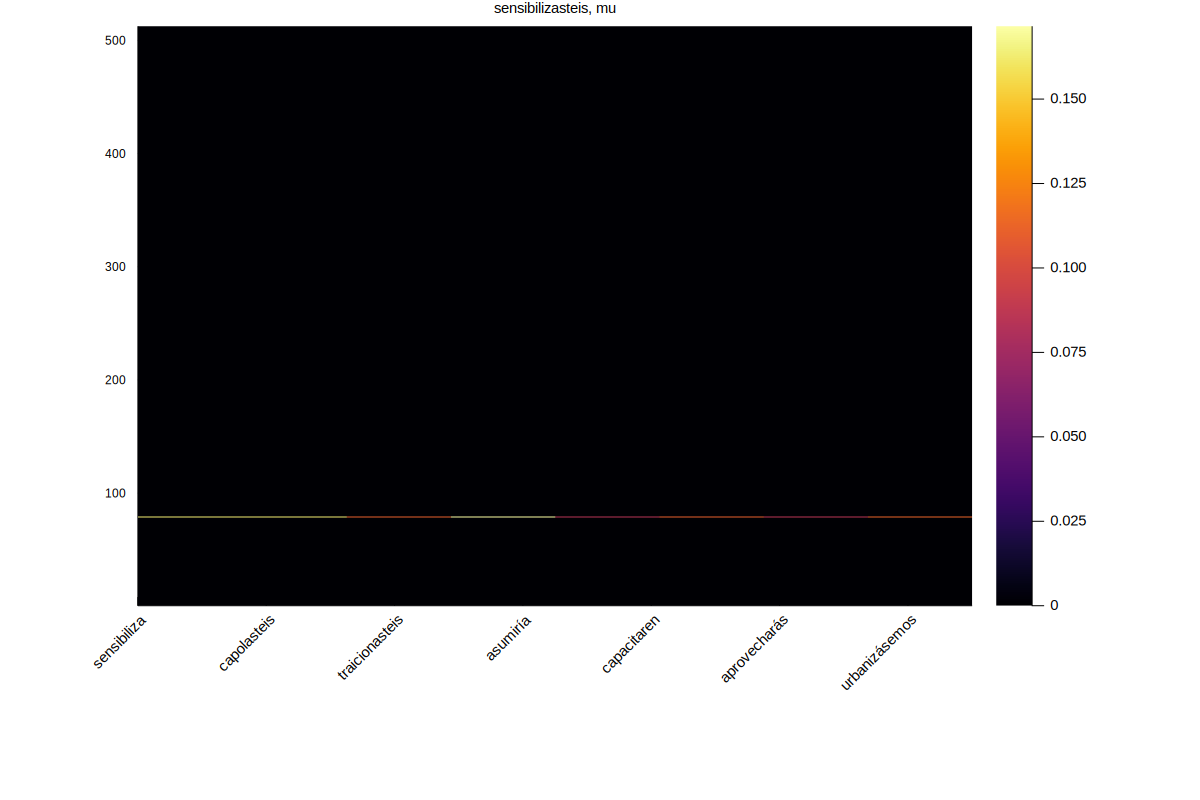

┌ Warning: GR: heatmap only supported with equally spaced data.
└ @ Plots /home/gridsan/eakyurek/.julia/packages/Plots/Iuc9S/src/backends/gr.jl:945


In [33]:
h1

# To-Dos
1. Add unrelated surface forms to the examplars too see whether the attention mappings are meaningful
2. Comparing with Normal Vae
3. Different Sampling Function on LM ($top_k$, temperature)
4. Attention in Decoder
5. Attention to the hidden state sequence, not just to the final state.
6. Metric for testing generation quality?

In [10]:
include("models.jl")
include("parser.jl")
KnetLayers.gc()

In [11]:
morph2 = VAE(length(vocab.chars); H=512, E=16, Z=16)
train_ae!(morph2, data, vocab; optim=Adam(), epoch=40);

(loss = 25.598727786254884,)
(loss = 20.936397186279297,)
(loss = 19.16912999267578,)
(loss = 17.31045026397705,)
(loss = 16.165051869201662,)
(loss = 15.361431550598144,)
(loss = 14.005281030273437,)
(loss = 12.630505657958985,)
(loss = 11.814711602783204,)
(loss = 11.128713945007323,)
(loss = 10.296028044128418,)


InterruptException: InterruptException:

In [12]:
morph3 = VAE(length(vocab.chars); H=512, E=16, Z=16)
copytoparams(morph3.encoder, morph2.encoder)
copytoparams(morph3.Wμ, morph2.Wμ)
copytoparams(morph3.Wσ, morph2.Wσ)
morph3.decoder.embedding = morph3.encoder.embedding
train_vae!(morph3, data, vocab; optim=Adam(), epoch=45, kl_weight=0.0f0, kl_rate = 0.1f0, fb_rate=4)

(kl_weight = 0.1f0, fbr = 4, loss = 19.375531831359865)
(kl_weight = 0.2f0, fbr = 4, loss = 18.9359036819458)
(kl_weight = 0.3f0, fbr = 4, loss = 18.36936686553955)
(kl_weight = 0.4f0, fbr = 4, loss = 18.296794905090334)
(kl_weight = 0.5f0, fbr = 4, loss = 18.267677139282227)
(kl_weight = 0.6f0, fbr = 4, loss = 18.297471125793457)


InterruptException: InterruptException:

In [56]:
samples = sample(morph3, vocab, edata; N=10000, useprior=true)

MethodError: MethodError: no method matching mapslices(::typeof(sample), ::AutoGrad.Result{Array{Float32,2}}; dims=1)
Closest candidates are:
  mapslices(::Any, !Matched::AbstractArray; dims) at abstractarray.jl:1973

In [57]:
samples[findall([s ∈ trainsfs for s in samples])]

5608-element Array{String,1}:
 "espolvorease" 
 "reteñiríais"  
 "reflexionáis" 
 "aruñabais"    
 "amarillecía"  
 "empodrecéis"  
 "empollaran"   
 "te arrodilles"
 ⋮              
 "embolsamos"   
 "acaparad"     
 "cabildeamos"  
 "no adames"    
 "vengarán"     
 "no infundas"  
 "sopasteis"    

In [58]:
samples[findall([s ∈ testsfs for s in samples])]

10-element Array{String,1}:
 "sistematizaba"
 "decore"       
 "puntaren"     
 "taconearíamos"
 "taconearíamos"
 "no laven"     
 "enrole"       
 "loqueare"     
 "desobstruimos"
 "doblegare"    

In [59]:
samples[findall([s ∈ dictsfs for s in samples])]

6804-element Array{String,1}:
 "espolvorease"  
 "reteñiríais"   
 "reflexionáis"  
 "aruñabais"     
 "amarillecía"   
 "empodrecéis"   
 "temblequeaseis"
 "empollaran"    
 ⋮               
 "cabildeamos"   
 "no adames"     
 "vengarán"      
 "indicen"       
 "no infundas"   
 "grademos"      
 "sopasteis"     

In [60]:
inters = sampleinter(morph3, vocab, data; N=10)

MethodError: MethodError: no method matching mapslices(::typeof(argmax), ::AutoGrad.Result{Array{Float32,2}}; dims=1)
Closest candidates are:
  mapslices(::Any, !Matched::AbstractArray; dims) at abstractarray.jl:1973

In [61]:
findall([s ∈ dictsfs for s in inters])

UndefVarError: UndefVarError: inters not defined

In [62]:
au, sigma, mu = calc_au(morph3, tdata; delta=0.01)

MethodError: MethodError: no method matching copyto!(::KnetArray{Float32,2}, ::Base.Broadcast.Broadcasted{Base.Broadcast.Style{AutoGrad.Value},Tuple{Base.OneTo{Int64},Base.OneTo{Int64}},typeof(identity),Tuple{AutoGrad.Result{KnetArray{Float32,2}}}})
Closest candidates are:
  copyto!(::Union{Array{T,N} where N, KnetArray{T,N} where N}, !Matched::Integer, !Matched::Union{Array{T,N} where N, KnetArray{T,N} where N}, !Matched::Integer, !Matched::Integer) where T at /home/gridsan/eakyurek/.julia/packages/Knet/FnyzM/src/karray.jl:323
  copyto!(::Union{Array{T,N} where N, KnetArray{T,N} where N}, !Matched::Union{Array{T,N} where N, KnetArray{T,N} where N}) where T at /home/gridsan/eakyurek/.julia/packages/Knet/FnyzM/src/karray.jl:332
  copyto!(!Matched::SubArray{A,B,C<:KnetArray,D,E}, ::Base.Broadcast.Broadcasted{S,X,F<:typeof(identity),T<:(Tuple{#s192} where #s192)}) where {A, B, C<:KnetArray, D, E, S, X, F<:typeof(identity), T<:(Tuple{#s192} where #s192)} at /home/gridsan/eakyurek/.julia/packages/Knet/FnyzM/src/karray.jl:1354
  ...

In [63]:
mi =  calc_mi(morph3,tdata)

MethodError: MethodError: no method matching KnetArray{Float32,N} where N(::AutoGrad.Result{Array{Float32,3}})
Closest candidates are:
  KnetArray{Float32,N} where N(!Matched::UndefInitializer, !Matched::Int64...) where {T, N} at /home/gridsan/eakyurek/.julia/packages/Knet/FnyzM/src/karray.jl:81
  KnetArray{Float32,N} where N(!Matched::UndefInitializer, !Matched::Tuple{Vararg{Int64,N}}) where {T, N} at /home/gridsan/eakyurek/.julia/packages/Knet/FnyzM/src/karray.jl:82
  KnetArray{Float32,N} where N(!Matched::UndefInitializer, !Matched::Integer...) where {T, N} at /home/gridsan/eakyurek/.julia/packages/Knet/FnyzM/src/karray.jl:83
  ...

In [64]:
calc_ppl(morph3,edata; nsample=500, B=16)

MethodError: MethodError: Cannot `convert` an object of type AutoGrad.Result{Float32} to an object of type Float32
Closest candidates are:
  convert(::Type{T<:Number}, !Matched::T<:Number) where T<:Number at number.jl:6
  convert(::Type{T<:Number}, !Matched::Number) where T<:Number at number.jl:7
  convert(::Type{T<:Number}, !Matched::Base.TwicePrecision) where T<:Number at twiceprecision.jl:250
  ...

In [65]:
include("models.jl")
include("parser.jl")

nsample_packed_sequence (generic function with 1 method)

In [66]:
model = LSTM_LM(length(vocab.chars); H=768, E=16)

(decoder = LSTM{Param{KnetArray{Float32,3}}, Multiply{Param{KnetArray{Float32,2}}}}(input=38,hidden=768,embed=16,dropout=0.4), output = Linear(Multiply{Param{KnetArray{Float32,2}}}(input=768 output=768), Bias{Param{KnetArray{Float32,1}}}(length=768)), hiddenSize = 768)

In [42]:
train_rnnlm!(model, data, vocab; epoch=40, optim=Adam(), B=16)

(loss = 2.565020043563843,)
(loss = 2.031818983268738,)
(loss = 1.91280202293396,)
(loss = 1.8352395069122314,)
(loss = 1.7840724544525146,)
(loss = 1.7377097730636597,)
(loss = 1.6949951625823974,)
(loss = 1.6514041450500487,)
(loss = 1.6078742918014526,)
(loss = 1.5658175846099853,)
(loss = 1.5220457862854004,)
(loss = 1.4798032117843627,)
(loss = 1.4404640241622926,)
(loss = 1.404750998878479,)
(loss = 1.371851237678528,)
(loss = 1.3426123491287232,)
(loss = 1.3129698717117309,)
(loss = 1.2844683826446532,)
(loss = 1.2616477149963379,)
(loss = 1.2366774326324463,)
(loss = 1.2134045652389527,)
(loss = 1.1957246425628663,)
(loss = 1.1736694137573243,)
(loss = 1.1563226512908935,)
(loss = 1.1420525296211244,)
(loss = 1.1263144080162049,)
(loss = 1.1144586671829224,)
(loss = 1.1005128566741944,)
(loss = 1.0922200533866881,)
(loss = 1.0810391907691956,)
(loss = 1.0751349632263183,)
(loss = 1.0672179356575011,)
(loss = 1.0587451880455017,)
(loss = 1.0532062746047974,)
(loss = 1.0481416421

In [43]:
 calc_ppllm(model, tdata)

6.610169732382499

In [44]:
samples = sample(model, vocab; N=10000)

10016-element Array{String,1}:
 "banalizabas"   
 "inscribiese"   
 "aturarían"     
 "consejas"      
 "rainase"       
 "matorizamos"   
 "reconvinieses" 
 "abejonea"      
 ⋮               
 "gilipeen"      
 "agarrotase"    
 "chaqueteaba"   
 "enmarañaréis"  
 "gravases"      
 "desvalorizaría"
 "uturasen"      

In [45]:
samples[findall([s ∈ trainsfs for s in samples])]

5289-element Array{String,1}:
 "banalizabas"   
 "inscribiese"   
 "aturarían"     
 "consejas"      
 "reconvinieses" 
 "abejonea"      
 "injuriaría"    
 "reimpusisteis" 
 ⋮               
 "mullíamos"     
 "no abrace"     
 "agarrotase"    
 "chaqueteaba"   
 "enmarañaréis"  
 "gravases"      
 "desvalorizaría"

In [46]:
samples[findall([s ∈ testsfs for s in samples])]

11-element Array{String,1}:
 "empedrare"    
 "mostremos"    
 "convergía"    
 "descreyésemos"
 "mordemos"     
 "sistematizaba"
 "enrole"       
 "cumplimentaba"
 "sistematizaba"
 "deshidratemos"
 "reunificarían"

In [47]:
samples[findall([s ∈ dictsfs for s in samples])]

6684-element Array{String,1}:
 "banalizabas"   
 "inscribiese"   
 "aturarían"     
 "consejas"      
 "reconvinieses" 
 "abejonea"      
 "injuriaría"    
 "reimpusisteis" 
 ⋮               
 "no abrace"     
 "avizorar"      
 "agarrotase"    
 "chaqueteaba"   
 "enmarañaréis"  
 "gravases"      
 "desvalorizaría"

In [48]:
 calc_ppllm(model, edata)

2.695941727858836